##### *Python libraries used in this notebook*

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import networkx as nx
from math import log2
import pandas as pd
import heapq

# Implementation of Hoffman`s algorithm

## Abstract
This notebook discusses Huffman's algorithm, comparing both lossy and lossless methods. It describes the operational principles of the Huffman algorithm and demonstrates an implementation of a compression method based on this algorithm using Python. The degree of compression for different types of texts has been evaluated, and the primary factors influencing the algorithm's efficiency have been deduced.

## 1. Huffman`s algorithm
Huffman coding, named after its inventor David A. Huffman, is a prominent method in computer science and information theory used for achieving lossless data compression. This technique employs a type of code known as a prefix code, ensuring that no bit sequence representing a symbol serves as the prefix for another symbol's sequence. Huffman introduced this algorithm in his 1952 paper titled "A Method for the Construction of Minimum-Redundancy Codes".

### 1.1 Difference between lossless and lossy compression
Digital files can be quite large. To address this issue, compression techniques are employed to reduce file sizes without compromising (for **lossless compression**) or with some acceptable compromise (for **lossy compression**) in quality. Two primary methods of compression are lossless and lossy compression.

#### 1.1.1 Lossless Compression 
**Definition:** Lossless compression aims to reduce file size without any loss of data. The decompressed file is an exact replica of the original file.

**How it works:** Lossless compression algorithms identify and eliminate redundant data within the file. Common techniques include:
> - Run-Length Encoding (RLE): Replaces repeated occurrences of a character or sequence with a count and the character/sequence, reducing the number of bits required.
> - Huffman Coding: Assigns shorter codes to frequently occurring characters and longer codes to less frequent ones, minimizing the overall bit usage.
> - Lempel-Ziv-Welch (LZW): Identifies and replaces recurring patterns in the data with shorter codes, further reducing redundancy.

**Pros:** No data is lost, so the original file can be perfectly reconstructed. Essential for applications where data integrity is crucial, like text documents, medical imaging, and some scientific data.\
**Cons:** Generally achieves less compression compared to lossy methods. May not be sufficient for applications requiring extreme reductions in file size.

Lossles compression is used to compress text files (ZIP, GZIP), images (PNG, LZW) and audio (FLAC, ALAC).

#### 1.1.2 Lossy Compression
**Definition:** Lossy compression reduces file size by permanently eliminating some data, particularly data that is considered less important or imperceptible to human senses.

**How it works:** It uses algorithms that remove redundant or less critical information. Common techniques include:
> - Transform Coding: Transforms data into a different domain (like frequency domain), then quantizes and encodes the less significant parts with fewer bits.
> - Quantization: Reduces the precision of less critical data points.
> - Entropy Coding: Further compresses the data after quantization.

**Pros:** Achieves much higher compression ratios compared to lossless methods. Suitable for applications where some loss of quality is acceptable, such as streaming media, online images, and consumer audio.

**Cons:** Some data is permanently lost, which can affect quality, especially at higher compression rates. Decompressed files are not identical to the original; repeated compression and decompression can degrade quality further.

Lossy compression is used to compress images (JPEG), audio (MP3, AAC) and video (MP4).

#### 1.1.3 Key Differences
- **Data Integrity:** Lossless compression retains all original data, while lossy compression sacrifices some data for smaller file sizes.
- **Compression Ratio:** Lossy compression generally achieves higher compression ratios compared to lossless.
- **Use Cases:** Lossless is used where data integrity is crucial; lossy is used where reduced file size is more important than perfect fidelity.

### 1.2 Applicability of lossless compression algoritms
Lossless compression algorithms are appropriate in the following situations:
- **Text Files:** When compressing text documents such as source code, configuration files, or any other textual data where exact reproduction of the original data is essential.
- **Executable Files:** For software distribution, where the integrity of the executable files must be maintained to ensure proper functionality.
- **Database Files:** In scenarios where data precision is critical, such as in database backups and archival, to ensure no data corruption.
- **Medical Imaging:** In medical applications (e.g., medical scans, MRI images) where any data loss could lead to misdiagnosis or incorrect treatment.
- **Scientific Data:** For scientific data and research where exact replication of data is necessary to maintain accuracy and reproducibility of results.
- **Financial Records:** In financial and legal documents where data integrity and accuracy are paramount.
- **Configuration and Log Files:** To ensure that configuration settings and logs are preserved exactly as they were originally recorded.
- **Audio and Image Files for Editing:** When working with audio, image, or video files in professional editing contexts where repeated saving and loading without quality degradation is required.
- **Version Control Systems:** In version control systems like Git, where it’s important to track exact changes in files over time.
- **Data Deduplication:** In scenarios where storage efficiency is achieved by eliminating duplicate copies of repeating data, requiring exact duplicates to be recognized and handled appropriately.

Lossless compression is preferred in these cases because it ensures that the original data can be perfectly reconstructed from the compressed data, maintaining data integrity and accuracy.

## 2. Huffman`s algorithm theory
### 2.1 Formalized description
**Input**\
We have the number of unique elements in the text that we will apply the algorithm to - Alphabet $A = (a_1, a_2,\dots, a_n)$, which is the symbol alphabet of size n.\
We have the probability of each element, i.e. the frequency of each element divided by the total number of elements - Tuple $W = (w_1, w_2, \dots, w_n)$, which is the tuple of the (positive) symbol weights (usually proportional to probabilities), i.e $w_i = weight(a_i), i \in \{1, 2,\dots, n\}$.

**Output**\
We expect for each element of the alphabet, its code correspondence as a binary code that is unique for each element - Code $C(W) = (c_1, c_2, \dots, c_n)$, which is the tuple of (binary) codewords, where $c_i$ is the codeword for $a_i, i \in \{1, 2, \dots, n\}$.

**Goal**\
The weighted average length of a code element - Length $L(C(W)) = \sum_{i = 1}^n w_i lenght(c_i)$ be the weighted path length of code $C$. Condition: $L(C(W)) \leq L(T(W))$ any arbitrary code that could also be applied $T(W)$.

**Example**\
We have the following string abcsddeeee, ten characters in total but five are unique. The following table presents the probability distribution for each unique symbol, the code word for each symbol (the way to determine the code words will be discussed later in a Hoffmann tree). It can be seen that the length of the code words is inversely proportional to the probability of encountering this symbol. The last row shows that the weighted average codeword length is 2.20 bits.

|Set       |element       |1   | 2  |3   | 4  | 5  |sum       |
-----------|--------------|----|----|----|----|----|----------|
|Input (A) | $(a_i)$      |a   |b   |c   |d   |e   | -      |
|Input (W) | $(w_i)$      |0.10|0.10|0.20|0.20|0.40|  = 1        |
|Output C  | $(c_i)$      |010 |011 |11  |00  |10  |  -       |
|Output C  | $(l_i)$      |3   |3   |2   |2   |2   |    -       |
|Output C  | $(l_i * w_i)$|0.30|0.30|0.40|0.40|0.80|L(C) = 2.20|

### 2.2 Information entropy (Shannon entropy)
In information theory, the concept of information entropy was introduced by Claude Shannon in his seminal 1948 paper "A Mathematical Theory of Communication," often referred to as Shannon entropy. Shannon's theory outlines a communication system comprising three fundamental components: a source that generates data, a channel through which data is transmitted, and a receiver that interprets the received signal. The central challenge, as articulated by Shannon, is for the receiver to accurately identify the original data generated by the source based on the transmitted signal.

Shannon explored various methods for encoding, compressing, and transmitting messages from a data source. He demonstrated through his source coding theorem that entropy represents a fundamental limit on how efficiently data from the source can be losslessly compressed onto a perfectly noiseless channel. For noisy channels, Shannon further extended this theory with his noisy-channel coding theorem.

In the context of a discrete random variable $\Chi$ with possible outcomes in the set $\chi$, nad distributed according to probability $p: \chi \rightarrow [0,1]$, the entropy $\Eta(X)$ is defined as:
$$\Eta(\Chi) := - \sum_{x\in\chi} p(x) \log p(x)$$
Here, $\sum$ denotes the summation over all possible values $x$ of the variable $\Chi$. The base of the logarithm $\log$ can vary depending on the application. Using base 2, for example, gives units of bits (or "shannons"), while base $e$ gives natural units (nats), and base 10 gives units like "dits," "bans," or "hartleys." Another formulation of entropy is as the expected value of the self-information of a variable.

The core principle of information theory posits that the informational content of a message is directly related to its surprise or uncertainty. A message carrying information about a highly improbable event is more informative than one about a highly probable event. For instance, knowing that a specific number will not win a lottery conveys little information due to its high probability, whereas knowing the winning number provides substantial information due to its low probability.

The information content, also called the surprisal or self-information, of an event $E$ is a function which increases as the probability $𝑝(𝐸)$ of an event decreases. When $𝑝(𝐸)$ is close to 1, the urprisal of the event is low, but if $𝑝(𝐸)$ is close to 0, the surprisal of the event is high. This relationship is described by the function:
$$\log\left(\frac{1}{p(E)}\right),$$
where $\log$ is the logarithm, which gives 0 surprise when the probability of the event is 1.\
Hence, we can define the information, or surprisal, of an event $𝐸$ by:
$$I(E) = -\log_2(p(E)),$$
or equivalently,
$$I(E) = \log_2\left(\frac{1}{p(E)}\right).$$
Entropy measures the expected (i.e., average) amount of information conveyed by identifying the outcome of a random trial.  This implies that rolling a die has higher entropy than tossing a coin because each outcome of a die toss has smaller probability $p = \frac{1}{6}$ than each outcome of a coin toss $𝑝 = \frac{1}{2}$.

Now we will calculate the entropy of all symbols from the example in point 2.1:
$$H(A) = -\sum_{w_i>0} w_i \log_2 w_i = (-0.10\log_2 0.10) + (-0.10\log_2 0.10) + (-0.20\log_2 0.20) + (-0.20\log_2 0.20) + (-0.40\log_2 0.40) 	\approx 2.12 $$
As a consequence of Shannon’s source coding theorem, entropy serves as a measure of the smallest possible codeword length theoretically achievable for a given alphabet with associated weights. In this example, the weighted average codeword length is 2.20 bits per symbol, which is only slightly larger than the calculated entropy of 2.12 bits per symbol. Thus, not only is this Huffman code optimal in the sense that no other feasible code could perform better, but it also approaches the theoretical limit established by Shannon very closely. This closeness underscores the efficiency and effectiveness of Huffman coding in minimizing the average length of encoded symbols relative to their probabilities.

### 2.3 Huffman tree
Huffman coding assigns variable-length codes to characters based on their frequencies, ensuring that no code is a prefix of another (prefix-free property). These codes are represented using a binary tree structure where characters are stored at the tree's leaves.

A Huffman tree, or Huffman coding tree, is a full binary tree where each leaf corresponds to a character in the given alphabet. The goal is to construct a tree that minimizes the weighted path length, where the weighted path length of a leaf is defined as its frequency multiplied by its depth.

Here's the step-by-step process to construct a Huffman tree:
1. **Frequency Calculation:** Calculate the frequency of each unique character in the input string. Characters with higher frequencies will be closer to the root of the tree.
2. **Priority Queue:** Create a priority queue (min-heap) where each node contains a character and its frequency. Initially, each unique character is a leaf node in this queue.
3. **Building the Tree:**
    - Remove the two nodes with the lowest frequencies from the priority queue.
    - Create a new internal node with these two nodes as children. The frequency of the new node is the sum of the frequencies of its children.
    - Insert the new node back into the priority queue.
    - Repeat the above steps until only one node remains in the priority queue. This node becomes the root of the Huffman tree.
4. **Assigning Codes:** Traverse the Huffman tree to assign binary codes (0 for left child, 1 for right child) to each character. The path from the root to each leaf node forms the unique code for that character.
5. **Encoding:** Replace each character in the original string with its corresponding Huffman code. This encoded string is represented in binary format, occupying less space than the original text.

#### 2.3.1 Constructing a Huffman tree
Let's illustrate this process with the string "ABABCACDEABE":\
We have the following sequence of symbols:
> 1. D - 1
> 2. E - 2
> 3. C - 2
> 4. B - 3
> 5. A - 4

We remove the two nodes with the smallest value - D and E and create a new node DE with a value of 3.


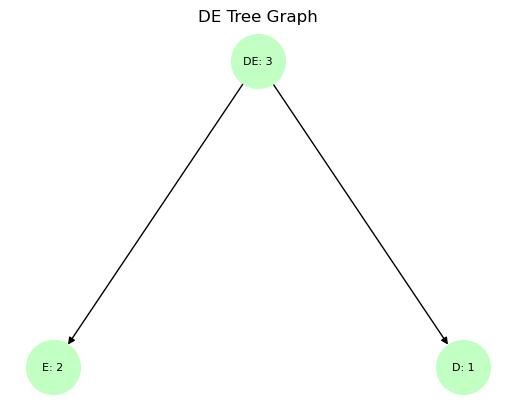

In [2]:
tree_dict = {
        1: {
            "D: 1":"DE: 3",
            "E: 2":"DE: 3"
            }
        }

# Create a NextworkX directed graph
g = nx.DiGraph()
g.add_nodes_from(['DE: 3'], subset=1)
g.add_nodes_from(tree_dict[1].keys(), subset=0)

# Add Title to Plot
plt.title('DE Tree Graph')

# Create a list of the edges
edges = []
for subset_stuff in tree_dict.values():
    for node, prev_node in subset_stuff.items():
        edges.append((prev_node, node))

# Draw the nodes with the multipartite layout
pos = nx.multipartite_layout(g, align='horizontal')
nx.draw(g, pos, with_labels=True, node_size=1500, node_color='#c2ffc2', font_size=8)

# Draw the edges with the multipartite layout
nx.draw_networkx_edges(g, pos, edgelist=edges, arrows=None, node_size=1500)
# Show the plot
plt.show()

Now have the following sequence:
> 1. C - 2
> 2. DE - 3
> 3. B - 3
> 4. A - 4

Again we remove the two nodes with the smallest value - C and DE and create a new node CDE with a value of 5, and the following sequence:
> 1. B - 3
> 2. A - 4
> 3. CDE - 5

Again we remove the two nodes with the smallest value - B and A and create a new node BA with a value of 7, and the following sequence:
> 1. CDE - 5
> 2. BA - 7

We also combine the last two nodes and get one node CDEBA - 12, which is the root of the tree.

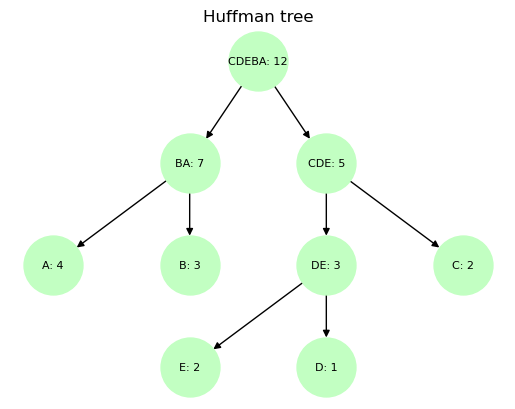

In [3]:
tree_dict = {
        1: {
            "CDE: 5":"CDEBA: 12",
            "BA: 7":"CDEBA: 12"
            },
         2: {
            "C: 2":"CDE: 5",
             "DE: 3":"CDE: 5",
            "B: 3":"BA: 7",
             "A: 4":"BA: 7"
            },
         3: {
            "D: 1":"DE: 3",
             "E: 2":"DE: 3"
            }
        }

# Create a NextworkX directed graph
g = nx.DiGraph()
g.add_nodes_from(['CDEBA: 12'], subset=3)
g.add_nodes_from(tree_dict[1].keys(), subset=2)
g.add_nodes_from(tree_dict[2].keys(), subset=1)
g.add_nodes_from(tree_dict[3].keys(), subset=0)

# Add Title to Plot
plt.title('Huffman tree')

# Create a list of the edges
edges = []
for subset_stuff in tree_dict.values():
    for index, (node, prev_node) in enumerate(subset_stuff.items(), start = 0):
        edges.append((prev_node, node, (0, 1) [index % 2 != 1]))

# Create a list of the lebels of edges
edga_labels = dict([((a,b,),v) for a,b,v in edges])

# Draw the nodes with the multipartite layout
pos = nx.multipartite_layout(g, align='horizontal')
nx.draw(g, pos, with_labels=True, node_size=1800, node_color='#c2ffc2', font_size=8)

# Draw the edges with the multipartite layout
nx.draw_networkx_edges(g, pos, edgelist=edges, arrows=None, node_size=1800)

# Show the plot
plt.show()

When all characters are stored in the leaf nodes and each internal (non-leaf) node has exactly two children, the encoding scheme defined by the 0/1 convention described above adheres to a crucial property known as the prefix property. This property ensures that no bit sequence encoding one character is a prefix of the bit sequence encoding any other character. This characteristic enables efficient decoding of a bitstream using the encoding tree by tracing paths from the root to the leaf nodes.

To facilitate decoding, we assign numbers to the left edges as 0 and to the right edges as 1. This numbering convention simplifies the traversal of the Huffman encoding tree during both encoding and decoding processes.

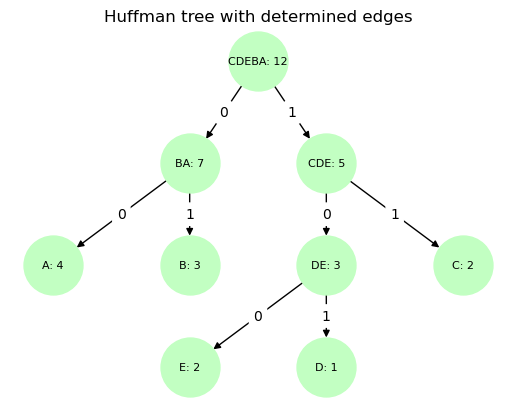

In [4]:
# Add Title to Plot
plt.title('Huffman tree with determined edges')

# Create a list of the lebels of edges
edga_labels = dict([((a,b,),v) for a,b,v in edges])

# Draw the nodes with the multipartite layout
pos = nx.multipartite_layout(g, align='horizontal')
nx.draw(g, pos, with_labels=True, node_size=1800, node_color='#c2ffc2', font_size=8)

# Draw the edges with the multipartite layout
nx.draw_networkx_edges(g, pos, edgelist=edges, arrows=None, node_size=1800)
nx.draw_networkx_edge_labels(g,pos,edge_labels=edga_labels, rotate=False)

# Show the plot
plt.show()

**Finally, we obtain the codeword for each symbol, as the string from the numbering of the edges from the root of the tree to the corresponding leaf, and obtain the following:**
> - A - 00,
> - B - 01,
> - C - 11,
> - E - 100,
> - D - 101,

Applying this code to the string "ABABCACDEABE", we get the encoded string: "000100011100111011000001100", which consists of 27 bits. Decoding is performed by reading from left to right, extracting one symbol at a time until a codeword matches, decoding it, and repeating until the entire string is decoded. The Huffman tree ensures that none of these codewords is a prefix of another: 00-A, 01-B, 11-C, 100-E, 101-D.


Next, we calculate the weighted average symbol length in the encoded string and the entropy of the encoded string based on the frequency and code length of each symbol.
|element        |A    | B  |C    | E   | D   |sum       |
|---------------|-----|----|-----|-----|-----|----------|
| $(w_i)$ weight|0.333|0.25|0.167|0.167|0.083|  = 1     |
| $(l_i)$ length|2    |2   |2    |3    |3    |    -     |
| $(l_i * w_i)$ |0.666|0.50|0.334|0.501|0.249|L(C) = 2.25|

$$H(A) = (-0.333\log_2 0.333) + (-0.25\log_2 0.25) + (-0.167\log_2 0.167) + (-0.167\log_2 0.167) + (-0.083\log_2 0.083) 	\approx 2.19 ~ bits $$

The weighted average length of the encoded string is approximately equal to the Shannon entropy, indicating that the Huffman codewords are optimally efficient for this string.

#### 2.3.2 Storage of Huffman Tree Information
When storing information about a Huffman tree for non-canonical codes, different Huffman trees may have different codewords for the same symbol. Hence, the exact tree used for compression must be preserved in the compressed file. This tree topology information is known as the header. The compressed file begins with three unsigned integers:
> - Total characters in the compressed file (4-byte unsigned integer).
> - Total characters used for header information (topology of Huffman tree) (4-byte unsigned integer).
> - Total characters in the original uncompressed file (4-byte unsigned integer).

Following these integers, the header information or Huffman coding tree topology is stored using post-order traversal. For each leaf node encountered, '1' followed by the ASCII character is written; for non-leaf nodes, '0' is written. An additional '0' marks the end of the tree structure. For instance, for the example string, the header is "1A1B01E1D01C000". This approach uses 7 bytes for the Huffman coding tree and 22 bytes for header and body, while the encoded character string is 12 bytes in size.

An alternative method is to specify the frequency of each unique symbol. For example, for the example string "ABABCACDEABE", the tree representation would be "A4B3E2C2D1". However, this method is less efficient as it requires more integer values, increasing the size of the encoded file (in this case, 25 bytes for 5 integers and 5 elements).

**Decoding Process**
When decoding an encoded file, the following steps should be followed:
1. **Building the Huffman Encoding Tree:** Using the information provided in the header of the encoded file:
    - Retrieve the total number of characters in the header (as indicated by the second number at the beginning of the encoded file).
    - Construct the Huffman encoding tree based on the topology stored in the header. This involves interpreting the sequence of '0's and '1's that represent nodes (non-leaf and leaf) in a post-order traversal fashion. Each '1' followed by an ASCII character represents a leaf node, and each '0' represents a non-leaf node until the terminating '0' indicates the end of the tree structure.
2. **Decoding the Body of the Encoded File:**
    - Read the body of the encoded file sequentially from left to right.
    - Append each new bit to an array.
    - Check if the sequence of bits in the array matches any codeword in the Huffman tree. Codewords are paths from the root of the tree to leaf nodes, where '0' denotes a left traversal and '1' denotes a right traversal.
    - Upon finding a matching codeword, decode the corresponding symbol associated with that codeword.
    - Reset the array and continue reading the body until all bits are processed.
3. **Handling Byte Alignment and End of File:**
    - Files are typically stored and processed in bytes (8 bits each). The last byte of the body might not be fully utilized if the number of bits is not a multiple of 8.
    - Any unused bits in the last byte are filled with zeros.
    - Determine the exact bit position within the body by subtracting the initial and header sizes from the total characters in the encoded file or by tracking the number of decoded characters.
    - Decoding concludes when the number of decoded characters matches the total characters in the original uncompressed file (as specified by the third number at the beginning of the encoded file).

For example, decoding the coded string "000100011100111011000001100" involves sequentially matching and decoding each codeword ("00" for "A", "01" for "B", etc.) until the entire string "ABABCACDEABE" is reconstructed from left to right.

This process ensures that the original data is reconstructed accurately using the Huffman encoding scheme preserved in the header of the encoded file.

## 3. Implementing of Huffman`s algorithm ##
For convenience, we'll implement a method that encodes, generates a Huffman tree topology, and decodes a string rather than a file. This will not have a significant impact on the analysis, as in addition to the encoded string and the tree topology, there are three additional numbers in the file encoding, the role of which was explained in point 2.3.2.

In [13]:
# HuffmanNode Class
class Huffman_node:
    # Constructor, initializes a node with a character, frequency, left and right child nodes
    def __init__(self, ch, frequency, left=None, right=None):
        self.ch = ch
        self.frequency = frequency
        self.left = left
        self.right = right
 
    # String representation of the node, showing character and frequency
    def __str__(self):
        return "(" + str(self.ch) + ", " + str(self.frequency) + ")"  
 
class Huffman_coding:
 # Method to get the root of the Huffman tree for the input string
    def get_root(self, input):
        freq_map = self.build_frequency_map(input) # Step 1: Build frequency map
        node_queue = self.sort_by_frequence(freq_map)  # Step 2: Sort nodes by frequency
        self.root = self.build_tree(node_queue) # Step 3: Build the Huffman tree
        return self.root
        
    # Method to get the Huffman codes for all characters in the input string
    def get_code(self,root):
        code_map = self.create_huffman_code(root) # Create Huffman codes
        return code_map
 
   # Step 1: Create character frequency map from input string
    def build_frequency_map(self, input):
        map = {}
        for c in input:
            map[c] = map.get(c,0) + 1 # Increment frequency count for each character
        return map
 
    # Step 2: Create a queue of nodes from the frequency map and sort by frequency
    def sort_by_frequence(self, map):
        queue = []
        for k, v in map.items():
            queue.append(Huffman_node(k, v, None, None))  # Create a node for each character     
        queue.sort(key = lambda x: x.frequency) # Sort the nodes by frequency
        return queue  
 
    #Step 3: Build frequency-sorted binary tree from sorted queue, return root    
    def build_tree(self, node_queue):             
        while len(node_queue) > 1:
            node1 = node_queue.pop(0) # Get the node with the lowest frequency
            node2 = node_queue.pop(0) # Get the node with the second lowest frequency
            node = Huffman_node('', node1.frequency + node2.frequency, node1, node2) # Merge nodes
            node_queue.append(node) # Add the merged node back to the queue
            node_queue.sort(key=lambda x: x.frequency)  # Re-sort the queue
        return node_queue.pop(0) # The last remaining node is the root
 
	# Step 4: Create a Huffman code map by performing a pre-order traversal of the tree
    def create_huffman_code(self, node):
        map = {}
        if node.left == None and node.right == None : # If have got one node
            map[node.ch] = '0'
        else:
            self.create_code_rec(node, map, "") # Helper method to create codes recursively
        return map
    
    # Pre-order traversal of the tree using recursion
    def create_code_rec(self, node, map, s):
        if node.left == None and node.right == None:
            map[node.ch] = s # If leaf node, add code to map
            return
        self.create_code_rec(node.left, map, s + '0') # Traverse left with '0'
        self.create_code_rec(node.right, map, s + '1') # Traverse right with '1'
 
    # Step 5: Use Huffman code to encode the input string
    def encode(self, code_map, input):
        return ''.join(code_map[ch] for ch in input)
 
    # Step 6: Decode the encoded string using the Huffman tree
    def decode(self, coded):
        s = ""
        curr = self.root
        if curr.left is None and curr.right is None:
            return curr.ch * len(coded)
        for i in range(len(coded)):
            curr = curr.right if coded[i] == '1' else curr.left
            if curr.left is None and curr.right is None:
                s += curr.ch
                curr = self.root
        return s

    # Method to traverse the Huffman tree and encode its topology
    def traverse_and_encode(self, node):
        result = []
        self._traverse_and_encode_helper(node, result)
        return ''.join(result)

    # Helper method for the traversal
    def _traverse_and_encode_helper(self, node, result):
        if node is None:
            return
        if node.left is None and node.right is None:
            result.append('1')
            result.append(node.ch)
        else:
            self._traverse_and_encode_helper(node.left, result)
            self._traverse_and_encode_helper(node.right, result)
            result.append('0')

In the above code, for convenience, we use 0 and 1 as numbers instead of bit values, so we will only use letters of the English alphabet for encoding strings. This limitation will not hinder the analysis of the efficiency of Huffman tree encoding, but it greatly simplifies the implementation. We will illustrate the possibilities that this implementation allows with the string "ABABABABAB".

In [16]:
string = "ABABABABAB"
result = {}

huffman = Huffman_coding() 

root = huffman.get_root(string)
traverce = huffman.traverse_and_encode(root) 
code_map = huffman.get_code(root)
uniq_symbol_input = len(code_map)
encoded = huffman.encode(code_map, string)
decode = huffman.decode(encoded)    
compresion = (len(encoded)  + (len(code_map) * 8) + (len(traverce) - len(code_map)) + 1)/ ((len(decode) * 8)) * 100

result["Origin string"] = string
result["Code words"] = code_map
result["Tree traverce"] = traverce
result["Encoded string"] = encoded
result["Decode string"] = decode
result["Compresion in percentage"] = compresion
for key, value in result.items():
    print(f"{key}: {value}")    

Origin string: ABABABABAB
Code words: {'A': '0', 'B': '1'}
Tree traverce: 1A1B0
Encoded string: 0101010101
Decode string: ABABABABAB
Compresion in percentage: 37.5


It is necessary to clarify the way of calculating the compression percentage, since, as already mentioned, the implementation does not use bits but 0 and 1. This is done using the following formula:
$$C = \frac{L_{encod} + (N_{unq} * 8) + (L_{trav} - N_{unq}) + 1 }{L_{inp} * 8} * 100$$
where:
- $C$ the compression ratio in percent;
- $L_{encod}$ the length of the encoded string;
- $N_{unq}$ the unique characters in the input string;
- $L_{trav}$ the number of characters in the string for the Huffman tree travers;
- $L_{inp}$ the length of the input string.

Alphanumeric characters are multiplied by 8 because they are assumed to be one byte in size. The formula does not include the size of the first three integers, the function of which is explained in point 2.3.2, because they have a constant value of 12 bytes. Also, no check is done if the number of bits is a multiple of 8, as this would have minimal impact.

## 4. Study of the algorithm
For this purpose, we will create 5 strings of 10 characters each, and the probability distribution will be as follows:
1. 0.1, i.e. 10 unique characters - "ABCDEFGJVH";
2. 0.2, i.e. 5 unique characters with two repetitions each - "AABBCCDDEE";
3. 0.3, 0.3, 0.4, i.e. three unique characters, the first and second with three repetitions, and the third with 4 - "AAABBBCCCC";
4. 0.5, i.e. two unique characters with five repetitions each - "AAAAABBBBB";
5. 1, i.e. one unique character with 10 repetitions - "AAAAAAAAAA";
6. 0.2, 0.2, 0.6, i.e. three unique characters, the first two with two  repetitions and the third with six repetitions - "AABBCCCCCC";
7. 0.1, 0.1, 0.8, i.e. three unique characters, the first two with one  repetition and the third with eight repetitions - "ABCCCCCCCC".

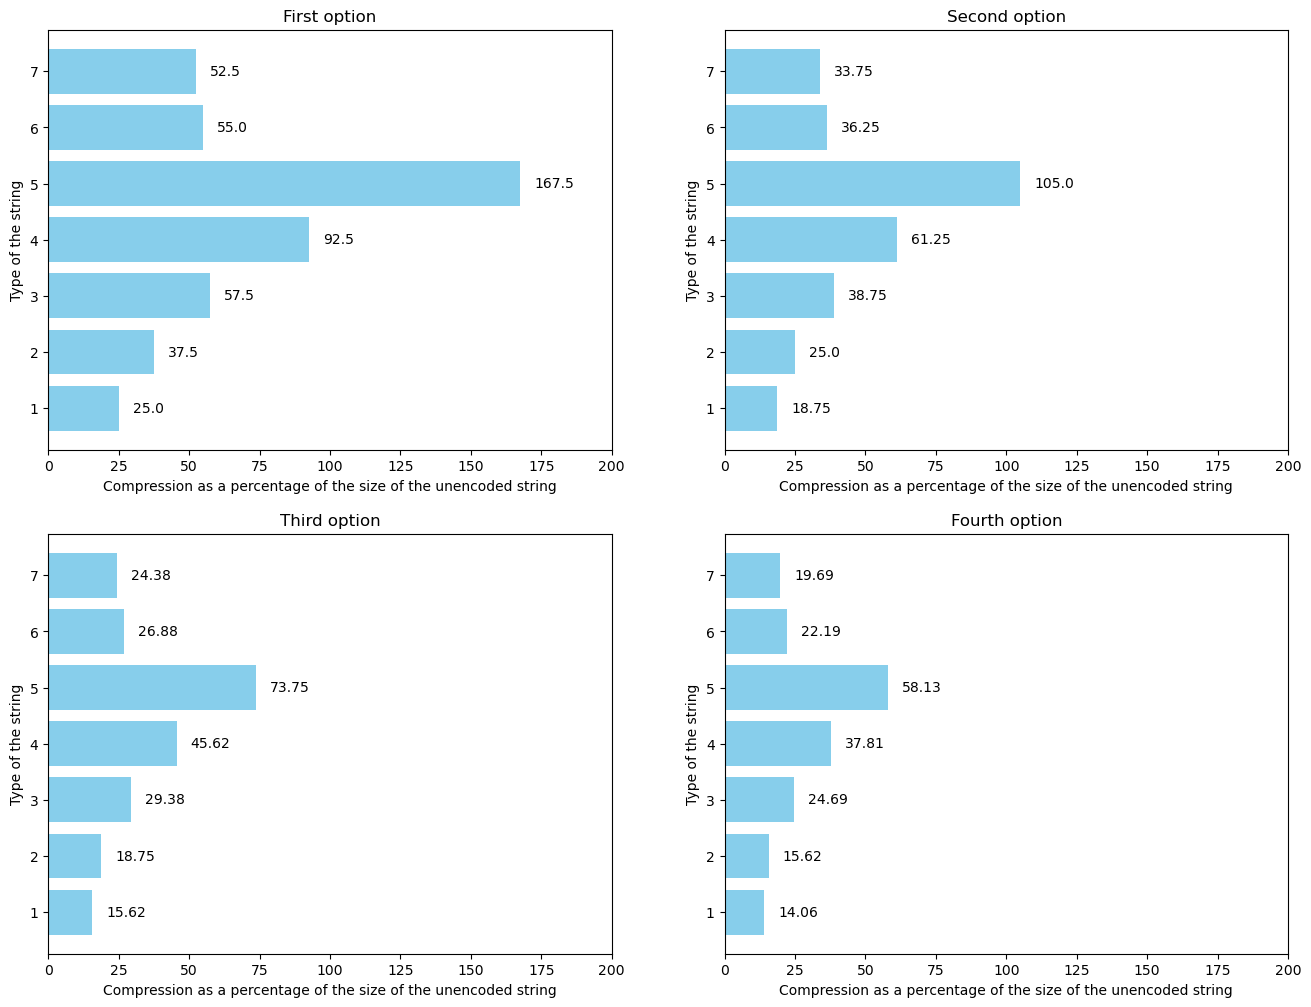

In [17]:
strings = ["AAAAAAAAAA", "AAAAABBBBB", "AAABBBCCCC", "AABBCCDDEE", "ABCDEFGJVH", "AABBCCCCCC", "ABCCCCCCCC"]

def get_compression_ratio(input):
    huffman = Huffman_coding()
    result = {}
    for index, string in enumerate(input):
        root = huffman.get_root(string)
        traverse = huffman.traverse_and_encode(root)
        code_map = huffman.get_code(root)
        uniq_symbol_input = len(code_map)
        encoded = huffman.encode(code_map, string)
        decoded = huffman.decode(encoded)
        compression = (len(encoded)  + (len(code_map) * 8) + (len(traverse) - len(code_map)) + 1)/ ((len(decoded) * 8)) * 100
        result[index + 1] = f"{compression:.2f}"
    return result

# Option with initial list strings
first_option = get_compression_ratio(strings)

# Option with doubled strings
for i in range(0, len(strings)):
    strings[i] *= 2

second_option = get_compression_ratio(strings)

# Option with quadrupled initial strings
for i in range(0, len(strings)):
    strings[i] *= 2
    
third_option = get_compression_ratio(strings)

# Option the original strings multiplied by eight
for i in range(0, len(strings)):
    strings[i] *= 2
    
fourth_option = get_compression_ratio(strings)

# Data first graph
x_first_option = list(first_option.keys())
y_first_option = [float(value) for value in first_option.values()]

# Data second graph
x_second_option = list(second_option.keys())
y_second_option = [float(value) for value in second_option.values()]

# Data third graph
x_third_option = list(third_option.keys())
y_third_option = [float(value) for value in third_option.values()]

# Data fourth graph
x_fourth_option = list(fourth_option.keys())
y_fourth_option = [float(value) for value in fourth_option.values()]

plt.figure(figsize=(16, 12))

# First graph
plt.subplot(2, 2, 1)
plt.barh(x_first_option, y_first_option,color='skyblue')
plt.xlim(0, 200)
for i in range(len(x_first_option)):
    plt.text(y_first_option[i] + 5, x_first_option[i], str(y_first_option[i]), va='center')
plt.xlabel('Compression as a percentage of the size of the unencoded string')
plt.ylabel('Type of the string')
plt.title('First option')

# Second graph
plt.subplot(2, 2, 2)
plt.barh(x_second_option, y_second_option,color='skyblue')
plt.xlim(0, 200)
for i in range(len(x_second_option)):
    plt.text(y_second_option[i] + 5, x_second_option[i], str(y_second_option[i]), va='center')
plt.xlabel('Compression as a percentage of the size of the unencoded string')
plt.ylabel('Type of the string')
plt.title('Second option')

# Third graph
plt.subplot(2, 2, 3)
plt.barh(x_third_option, y_third_option,color='skyblue')
plt.xlim(0, 200)
for i in range(len(x_third_option)):
    plt.text(y_third_option[i] + 5, x_third_option[i], str(y_third_option[i]), va='center')
plt.xlabel('Compression as a percentage of the size of the unencoded string')
plt.ylabel('Type of the string')
plt.title('Third option')

# Fourth graph
plt.subplot(2, 2, 4)
plt.barh(x_fourth_option, y_fourth_option,color='skyblue')
plt.xlim(0, 200)
for i in range(len(x_fourth_option)):
    plt.text(y_fourth_option[i] + 5, x_fourth_option[i], str(y_fourth_option[i]), va='center')
plt.xlabel('Compression as a percentage of the size of the unencoded string')
plt.ylabel('Type of the string')
plt.title('Fourth option')

plt.show()

For all strings, doubling their length increases encoding efficiency. This is most clearly seen in the fifth string, where the distribution of elements is 10 percent. In the first option, which consists of practically 10 unique characters, compression has the opposite effect: the size of the file with the compressed code will be larger than the original. This remains true when doubling the string. However, when quadrupling it, the size of the compressed file will be smaller than the original (not taking into account the effect of the three leading numbers). It is clear that with each subsequent doubling of string size, the rate of increase in compression ratio slows down, and this applies to all strings.

Another notable trend is related to the number of unique characters in each string. The code is most efficient when the first string has only one unique character. The fewer unique characters in the string, the higher the compression rate. However, when doubling the string while preserving the frequency distribution, the percentage increase in the rate of compression is lower. The most efficient code is on the first string, which has only one unique character. For strings 3, 6, and 7, which have three unique characters each, the thesis is confirmed: the more asynchronous the probability distribution, the more efficient the compression. String 7 has one dominant symbol at 80 percent, and in every variation, it has the most compression of the three strings (2, 6, and 7).

The analysis confirms that the efficiency of coding with the Huffman algorithm depends on the total size of the coded data, the number of unique symbols, and their frequency distribution. There are three main factors that affect the compression ratio:
- Increasing the data volume while preserving the number of unique symbols and their frequency distribution increases the compression ratio.
- Decreasing the number of unique symbols while maintaining the data size and without significantly changing the distribution results in increased compression.
- Increasing the asynchrony of the distribution of the frequency of the unique symbols while keeping the other two factors leads to an increase in the degree of compression.
  
In conclusion, it can be confirmed that the Huffman algorithm is most effective for compressing files with a large number of symbols, few of which are unique, and that have a highly asynchronous frequency distribution.

## References

1. <a href="https://en.wikipedia.org/wiki/Huffman_coding">Wikipedia - Huffman`s coding</a>
2. <a href="https://en.wikipedia.org/wiki/Lossy_compression">Wikipedia - Lossy compression</a>
3. <a href="https://en.wikipedia.org/wiki/Lossless_compression">Wikipedia - Lossless compression</a>
4. <a href="https://www.khanacademy.org/computing/computers-and-internet/xcae6f4a7ff015e7d:digital-information/xcae6f4a7ff015e7d:data-compression/a/lossy-compression">Khanacademy - Lossy compression</a>
5. <a href="https://en.wikipedia.org/wiki/Entropy_(information_theory)">Wikipedia - Entropy</a>
6. <a href="https://https://engineering.purdue.edu/ece264/17au/hw/HW13?alt=huffman">Huffman Coding</a>
6. <a href="https://github.com/seanbeaulieu/huffmans_algorithm/blob/main/huffman.py">Implentation Sean Beaulieu</a>
7. <a href="https://github.com/bhrigu123/huffman-coding/blob/master/huffman.py">Implentation Bhrigu Srivastava</a>